In [19]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import quandl
import sys
import scipy.optimize as scoplt
import datetime as dt              # working with dates
import json                        # parse json into a list
import requests                    # for "get" request to API

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff

plt.style.use('fivethirtyeight')
np.random.seed(777)
def get_binance_coin(symbol, startTime, endTime): 
    url = "https://api.binance.com/api/v3/klines"

    startTime = str(int(startTime.timestamp() * 1000))
    endTime = str(int(endTime.timestamp() * 1000))
    limit = '1000'

    req_params = {"symbol" : symbol, 'interval' : '1d', 'startTime' : startTime, 'endTime' : endTime, 'limit' : limit}

    #get raw json data & frame it
    raw = json.loads(requests.get(url, params = req_params).text )
    data = pd.DataFrame(raw)

    #format columns name
    data.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume','close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore']
    data.index = [dt.datetime.fromtimestamp(x/1000.0) for x in data.datetime]
    data.set_index(pd.DatetimeIndex(data['datetime']))
    data = data.astype(float)
    data = data.rename(columns={'close': symbol})
    data = data[symbol]
    return data


def download(tickers, start ,end):
    assets = pd.DataFrame()
    for ticker in tickers:
        print (ticker)
        coin = get_binance_coin(ticker, start, end)
        assets = pd.concat([assets, coin], axis=1) 
    assets.index = pd.to_datetime(assets.index)
    return assets


In [20]:
data = download(['SNXUSDT','AUDIOUSDT','C98USDT'], dt.datetime(2021, 8, 1), dt.datetime(2021, 11, 1) )
#data = yf.download(['BTC-USD','ETH-USD','XRP-USD','LINK-USD'],start="2019-01-01",end="2021-01-01")
#data = yf.download(['AAPL','NKE','GOOGL','AMZN'],start="2018-01-01",end="2021-01-01")

daily_returns = data
#data = data['Adj Close']
data

SNXUSDT
AUDIOUSDT
C98USDT


,SNXUSDT,AUDIOUSDT,C98USDT
2021-08-01 19:00:00,9.490,1.1210,1.14903
2021-08-02 19:00:00,9.051,1.0747,1.13430
2021-08-03 19:00:00,9.653,1.1409,1.14275
2021-08-04 19:00:00,10.522,1.1730,1.10309
2021-08-05 19:00:00,10.185,1.3474,1.11000
...,...,...,...
2021-10-27 19:00:00,9.699,1.9740,3.64000
2021-10-28 19:00:00,10.356,2.0530,3.72000
2021-10-29 19:00:00,9.869,2.3180,3.60100
2021-10-30 19:00:00,10.140,2.2230,3.67600


In [21]:
# Calculate daily return. 
daily_returns = np.log(1+daily_returns.pct_change())

#daily_returns = np.log(1+daily_returns['Adj Close'].pct_change())
daily_returns

,SNXUSDT,AUDIOUSDT,C98USDT
2021-08-01 19:00:00,NaN,NaN,NaN
2021-08-02 19:00:00,-0.047363,-0.042180,-0.012902
2021-08-03 19:00:00,0.064393,0.059776,0.007422
2021-08-04 19:00:00,0.086200,0.027747,-0.035322
2021-08-05 19:00:00,-0.032552,0.138612,0.006245
...,...,...,...
2021-10-27 19:00:00,0.045995,0.024617,0.038935
2021-10-28 19:00:00,0.065543,0.039240,0.021740
2021-10-29 19:00:00,-0.048168,0.121403,-0.032512
2021-10-30 19:00:00,0.027089,-0.041847,0.020614


In [22]:
# remove first row (can't be calcualted).
daily_returns = daily_returns.drop(daily_returns.index[0])
daily_returns



,SNXUSDT,AUDIOUSDT,C98USDT
2021-08-02 19:00:00,-0.047363,-0.042180,-0.012902
2021-08-03 19:00:00,0.064393,0.059776,0.007422
2021-08-04 19:00:00,0.086200,0.027747,-0.035322
2021-08-05 19:00:00,-0.032552,0.138612,0.006245
2021-08-06 19:00:00,0.037482,-0.001040,0.015022
...,...,...,...
2021-10-27 19:00:00,0.045995,0.024617,0.038935
2021-10-28 19:00:00,0.065543,0.039240,0.021740
2021-10-29 19:00:00,-0.048168,0.121403,-0.032512
2021-10-30 19:00:00,0.027089,-0.041847,0.020614


Text(0, 0.5, 'price in $')

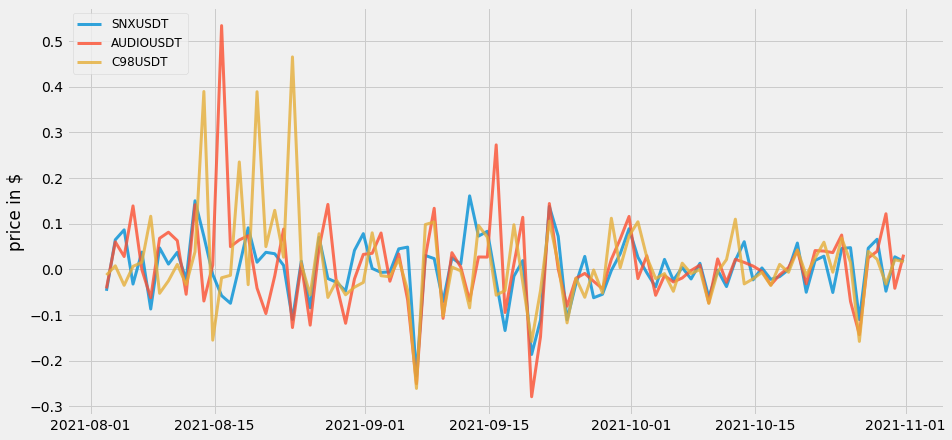

In [23]:

plt.figure(figsize=(14, 7))
for c in daily_returns.columns.values:
    plt.plot(daily_returns.index, daily_returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'Cumulative Returns')

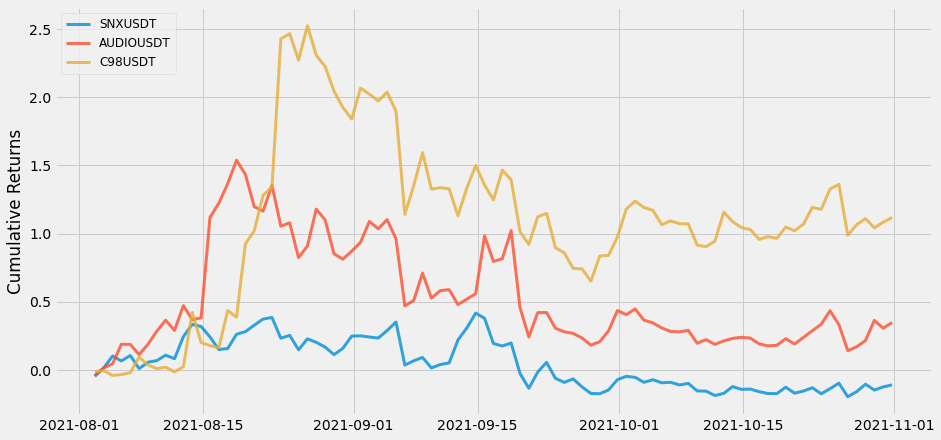

In [24]:
cumulative_ret = (1 + daily_returns).cumprod() - 1
plt.figure(figsize=(14, 7))
for c in cumulative_ret.columns.values:
    plt.plot( cumulative_ret[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Cumulative Returns')

In [25]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [ ]:
returns = daily_returns
mean_returns = returns.mean()
#mean_returns
cov_matrix = returns.cov()
corr_matrix = daily_returns.apply(lambda x: np.log(1+x)).corr()


ind_er = data.resample('Y').last().pct_change().mean()
#ind_er
ann_sd = daily_returns.apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
#ann_sd
#mean_returns
corr_matrix

In [ ]:
assets = pd.concat([ind_er, ann_sd], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
assets

In [ ]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(daily_returns.columns)
num_portfolios = 20000
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)
    


In [ ]:
data2 = {'Returns':p_ret, 'Volatility':p_vol}
for counter, symbol in enumerate(daily_returns.columns.tolist()):
    #print(counter, symbol)
    data2[symbol+' weight'] = [w[counter] for w in p_weights]
    
portfolios  = pd.DataFrame(data2)

In [ ]:
portfolios.head() # Dataframe of the 10000 portfolios created

In [31]:
# Finding the optimal portfolio
rf = 0.01 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port


TypeError: Cannot index by location index with a non-integer key

In [ ]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
min_vol_port

In [ ]:
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)
plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
plt.xlabel('Annualised volatility')
plt.ylabel('Annualised Returns (%)')